# Biosensing Analysis

### This notebook walks through the biosensing analysis: segmenting the image, calculating intensity and plotting against refractive index

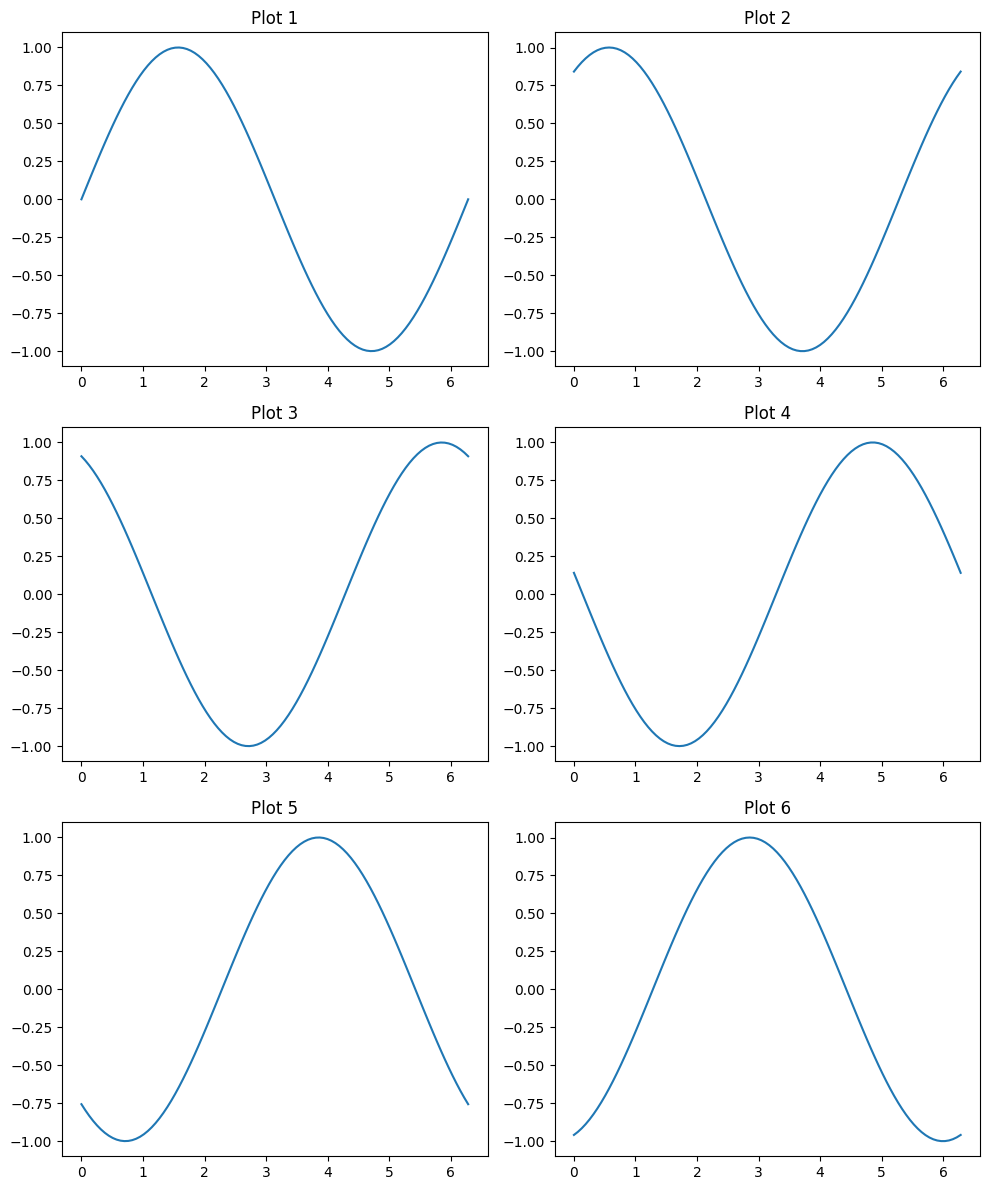

In [9]:
from analysis.data_preprocessing import data_preprocessing 
from analysis.analysis import intensity_analysis
from analysis.utils import create_plots
from segmentation.sam2wrapper import SAM2Wrapper
import numpy as np
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from segmentation.helpers import show_anns
from scipy.stats import linregress

create_plots(6)

### Extract NaCl percentage and images

In [2]:
data_dir = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Raw/Chip2-NaCl 0-19_"
            
data = data_preprocessing(data_dir, equals="290-4-0.75x-3")

### Initialize SAM2

In [3]:
model = SAM2Wrapper(points_per_side=8)

==== Using device: cpu ====
==== SAM2AutomaticMaskGenerator initialized ====


### Perform Segmentation

center: (730, 790), radius: 26
center: (452, 803), radius: 27
center: (591, 796), radius: 27
center: (584, 623), radius: 11
center: (722, 616), radius: 10
center: (584, 623), radius: 11
center: (722, 616), radius: 10
center: (730, 790), radius: 26
center: (452, 803), radius: 27
center: (591, 796), radius: 27


c:\Users\Micha\Desktop\BachelorProject\AI-Powered-Biosensing\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Micha\Desktop\BachelorProject\AI-Powered-Biosensing\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Micha\Desktop\BachelorProject\AI-Powered-Biosensing\.venv\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Micha\Desktop\BachelorProject\AI-Powered-Biosensing\.venv\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Micha\Desktop\BachelorProject\AI-Powered-Biosensing\.venv\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid va

center: (729, 790), radius: 26
center: (452, 803), radius: 27
center: (591, 796), radius: 27
center: (584, 623), radius: 10
center: (722, 616), radius: 10
center: (584, 623), radius: 10
center: (722, 616), radius: 10
center: (729, 790), radius: 26
center: (452, 803), radius: 27
center: (591, 796), radius: 27
center: (456, 901), radius: 26
center: (447, 609), radius: 10
center: (585, 602), radius: 10
center: (724, 595), radius: 11
center: (447, 609), radius: 10
center: (585, 602), radius: 10
center: (724, 595), radius: 11
center: (456, 901), radius: 26
center: (456, 903), radius: 27
center: (447, 611), radius: 10
center: (585, 603), radius: 10
center: (723, 597), radius: 10
center: (447, 611), radius: 10
center: (585, 603), radius: 10
center: (723, 597), radius: 10
center: (456, 903), radius: 27
center: (457, 919), radius: 26
center: (596, 912), radius: 27
center: (735, 906), radius: 27
center: (585, 619), radius: 10
center: (447, 627), radius: 11
center: (724, 611), radius: 10
center: 

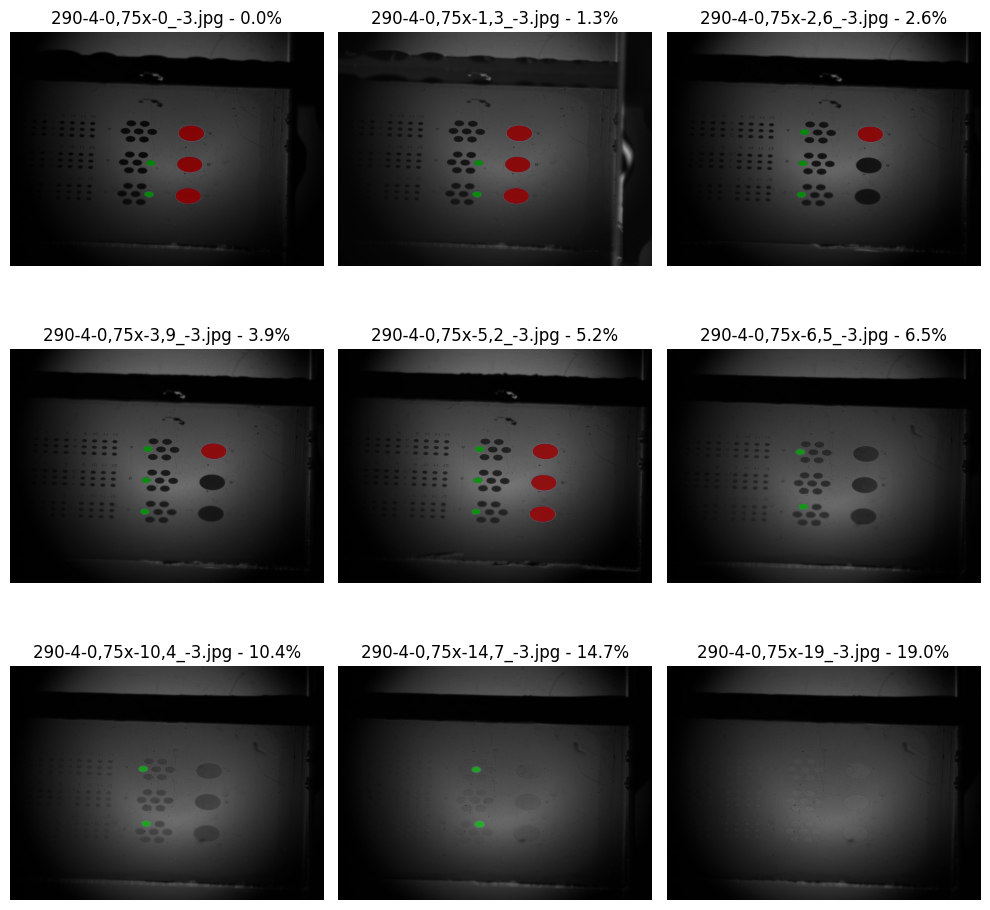

ValueError: Inputs must not be empty.

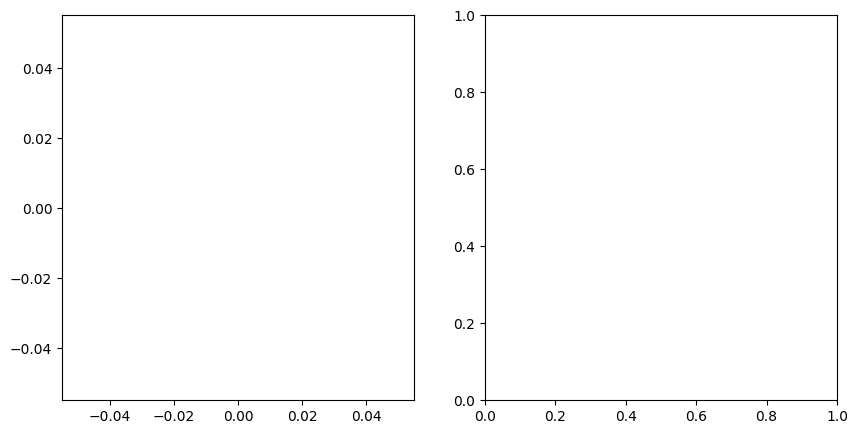

In [ ]:
for group, items in data.items():
    calibration_data = []
    for item in items:
        calibration_data.append(intensity_analysis(item, model))
        
    # Create DataFrame and sort by NaCl percentage
    df_data = pd.DataFrame(calibration_data).sort_values('NaCl_percentage')
    df_data = df_data.drop(columns=['masks', 'masks_large', 'masks_medium', 'masks_small'])
    
    # Fill NaN values with 0 if the entire column is NaN
    df_data.loc[:, df_data.isna().all()] = 0 
    
    # Compute refractive index (RI) using a simplified linear model
    df_data['RI'] = 1.3330 + 0.0018 * df_data['NaCl_percentage']
    # Drop rows with NaN values
    df_calibration = df_data.dropna()

    # Draw 9 plots visualizing the detected masks filtered by large, medium, small
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            ax = axes[i, j]
            masks_large = calibration_data[idx]["masks_large"]
            masks_medium = calibration_data[idx]["masks_medium"]
            masks_small = calibration_data[idx]["masks_small"]
            masks = calibration_data[idx]["masks"]
            
            if len(masks) == len(masks_large) + len(masks_medium) + len(masks_small):
                print(f"Image {idx} - {calibration_data[idx]['image_name']} has all masks")
                
            image_path = calibration_data[idx]["image_path"]

            ax.imshow(np.array(Image.open(image_path)))
            ax.set_title(f"{os.path.basename(image_path)} - {calibration_data[idx]['NaCl_percentage']}%")
            if masks_large:
                show_anns(masks_large, ax=ax, color=np.array([1.0, 0.0, 0.0, 0.5]))
            if masks_medium:
                show_anns(masks_medium, ax=ax, color=np.array([0.0, 1.0, 0.0, 0.5]))
            # if masks_small:
            #     show_anns(masks_small, ax=ax, color_mask=np.array([0.0, 0.0, 1.0, 0.5]))
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    # Draw 3 plots visualizing the average intensity vs RI by well size
    # Plot the calibration curve - large
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].errorbar(df_calibration['RI'], df_calibration['mean_intensity_large'],
                 yerr=df_calibration['std_intensity_large'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # Perform linear regression - large
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_large']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[0].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - large
    for i, row in df_calibration.iterrows():
        axes[0].annotate(f"{row['NaCl_percentage']}%",
                     (row['RI'], row['mean_intensity_large']),
                     xytext=(5, 5), textcoords='offset points')

    axes[0].set_title(f'Calibration Curve - Large Wells')
    axes[0].set_xlabel('Refractive Index (RI)')
    axes[0].set_ylabel('Mean Intensity (AU/pixel)')
    axes[0].grid(False)
    axes[0].legend(loc="upper left")
    
    # Plot the calibration curve - medium
    axes[1].errorbar(df_calibration['RI'], df_calibration['mean_intensity_medium'],
                 yerr=df_calibration['std_intensity_medium'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # Perform linear regression - medium
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_medium']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[1].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - medium
    for i, row in df_calibration.iterrows():
        axes[1].annotate(f"{row['NaCl_percentage']}%",
                     (row['RI'], row['mean_intensity_medium']),
                     xytext=(5, 5), textcoords='offset points')

    axes[1].set_title(f'Calibration Curve - Medium Wells')
    axes[1].set_xlabel('Refractive Index (RI)')
    axes[1].set_ylabel('Mean Intensity (AU/pixel)')
    axes[1].grid(False)
    axes[1].legend(loc="upper left")
    
    # # Plot the calibration curve - small
    axes[2].errorbar(df_calibration['RI'], df_calibration['mean_intensity_small'],
                 yerr=df_calibration['std_intensity_small'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # # Perform linear regression - small
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_small']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[2].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # # Annotate points with NaCl percentages - small
    for i, row in df_calibration.iterrows():
        axes[2].annotate(f"{row['NaCl_percentage']}%",
                     (row['RI'], row['mean_intensity_small']),
                     xytext=(5, 5), textcoords='offset points')

    axes[2].set_title(f'Calibration Curve - Small Wells')
    axes[2].set_xlabel('Refractive Index (RI)')
    axes[2].set_ylabel('Mean Intensity (AU/pixel)')
    axes[2].grid(False)
    axes[2].legend()
    
    # Plot the calibration curve - all
    axes[3].errorbar(df_calibration['RI'], df_calibration['mean_intensity_all'],
                 yerr=df_calibration['std_intensity_all'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # Perform linear regression - all
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_all']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[3].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - all
    for i, row in df_calibration.iterrows():
        axes[3].annotate(f"{row['NaCl_percentage']}%",
                     (row['RI'], row['mean_intensity_all']),
                     xytext=(5, 5), textcoords='offset points')

    axes[3].set_title(f'Calibration Curve - All Wells')
    axes[3].set_xlabel('Refractive Index (RI)')
    axes[3].set_ylabel('Mean Intensity (AU/pixel)')
    axes[3].grid(False)
    axes[3].legend()
    fig.savefig("large_medium_wells_plot.svg", format='svg', dpi=300, bbox_inches='tight', transparent=True)
    
    plt.tight_layout()
    plt.show()
    
    # Output calibration data and regression results
    print("\n===== Calibration Data =====")
    print(df_data.to_string(index=False))
        
        